In [1]:
from flask import Flask
from googleapiclient.discovery import build
#from apiclient.discovery import build
from oauth2client.service_account import ServiceAccountCredentials
import httplib2
#from urllib2 import HTTPError
#from slackclient import SlackClient
import json
import time
import datetime
from pprint import pprint
#from google.cloud import bigquery
#from google.cloud import logging
import uuid
import logging

%matplotlib inline

In [56]:
from bigquery import get_client
json_key = 'eam-poc-realtime-5a6f52eaaec6.json'
client = get_client(json_key_file=json_key, readonly=False)


Traceback (most recent call last):
  File "/Users/jose/Documents/GitHub/google_cloud_playground/real_time_dashboard_client/venv/lib/python2.7/site-packages/googleapiclient/discovery_cache/__init__.py", line 41, in autodetect
    from . import file_cache
  File "/Users/jose/Documents/GitHub/google_cloud_playground/real_time_dashboard_client/venv/lib/python2.7/site-packages/googleapiclient/discovery_cache/file_cache.py", line 41, in <module>
    'file_cache is unavailable when using oauth2client >= 4.0.0')
ImportError: file_cache is unavailable when using oauth2client >= 4.0.0
INFO:googleapiclient.discovery:URL being requested: GET https://www.googleapis.com/discovery/v1/apis/bigquery/v2/rest
INFO:oauth2client.transport:Attempting refresh to obtain initial access_token
INFO:oauth2client.client:Refreshing access_token


In [3]:
# Submit an async query
job_id, _results = client.query("  SELECT STRFTIME_UTC_USEC(DATE_ADD(USEC_TO_TIMESTAMP(TIMESTAMP(ds)), 60, 'MINUTE'), '%Y-%m-%d %H:%M') as ds, sum(y) as y from[eam-poc-realtime:streaming.active_users] group by ds order by ds desc", timeout=10)

# Do other stuffs

# Poll for query completion.
complete, row_count = client.check_job(job_id)

# Retrieve the results.
if complete:
    ts = client.get_query_rows(job_id)

In [4]:
import pandas as pd
import numpy as np
from fbprophet import Prophet

In [5]:
df = pd.DataFrame(ts)

In [6]:
df.describe()

y
count  1966.000000
mean     90.781790
std      62.946245
min       1.000000
25%      27.000000
50%      89.000000
75%     149.000000
max     239.000000

In [7]:
df.iloc[:,1:].values

array([[132],
       [125],
       [126],
       ..., 
       [ 47],
       [ 47],
       [ 48]])

In [8]:

def safe_ln(x, minval=0.0000000001):
    return np.log(x.clip(min=minval))



df['y'] = safe_ln(df.iloc[:,1:].values) 
df.head()

ds         y
0  2017-11-22 09:31  4.882802
1  2017-11-22 09:30  4.828314
2  2017-11-22 09:29  4.836282
3  2017-11-22 09:28  4.770685
4  2017-11-22 09:27  4.859812

In [9]:

#df['y'] = np.log(df['y']) 
df.head()

ds         y
0  2017-11-22 09:31  4.882802
1  2017-11-22 09:30  4.828314
2  2017-11-22 09:29  4.836282
3  2017-11-22 09:28  4.770685
4  2017-11-22 09:27  4.859812

In [10]:
m = Prophet(daily_seasonality=True)
m.fit(df);

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [11]:
future = m.make_future_dataframe(periods=5, freq='1min', include_history=True)
future.sort_values(by='ds',ascending=False).tail(10)

ds
9 2017-11-21 00:55:00
8 2017-11-21 00:54:00
7 2017-11-21 00:53:00
6 2017-11-21 00:52:00
5 2017-11-21 00:51:00
4 2017-11-21 00:50:00
3 2017-11-21 00:49:00
2 2017-11-21 00:48:00
1 2017-11-21 00:47:00
0 2017-11-21 00:46:00

In [12]:
fcst = m.predict(future)


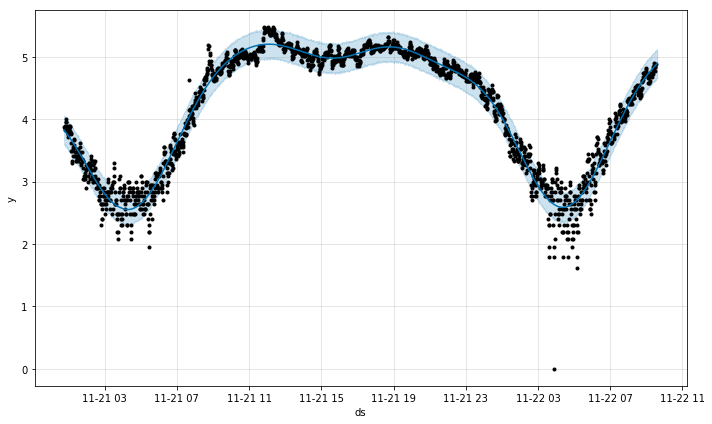

In [13]:
m.plot(fcst);

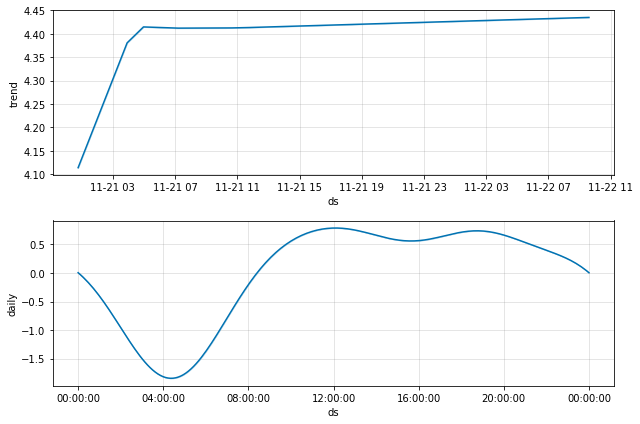

In [14]:
m.plot_components(fcst);


In [15]:
fcst.head()

ds     trend  trend_lower  trend_upper  yhat_lower  \
0 2017-11-21 00:46:00  4.114094     4.114094     4.114094    3.589321   
1 2017-11-21 00:47:00  4.115504     4.115504     4.115504    3.596334   
2 2017-11-21 00:48:00  4.116915     4.116915     4.116915    3.581483   
3 2017-11-21 00:49:00  4.118326     4.118326     4.118326    3.559504   
4 2017-11-21 00:50:00  4.119737     4.119737     4.119737    3.586199   

   yhat_upper     daily  daily_lower  daily_upper  seasonal  seasonal_lower  \
0    4.050551 -0.292262    -0.292262    -0.292262 -0.292262       -0.292262   
1    4.048874 -0.299905    -0.299905    -0.299905 -0.299905       -0.299905   
2    4.045562 -0.307596    -0.307596    -0.307596 -0.307596       -0.307596   
3    4.034710 -0.315335    -0.315335    -0.315335 -0.315335       -0.315335   
4    4.042325 -0.323121    -0.323121    -0.323121 -0.323121       -0.323121   

   seasonal_upper  seasonalities  seasonalities_lower  seasonalities_upper  \
0       -0.292262      -0.292262            -0.292262            -0.292262   
1       -0.299905      -0.299905            -0.299905            -0.299905   
2       -0.307596      -0.307596            -0.307596            -0.307596   
3       -0.315335      -0.315335            -0.315335            -0.315335   
4       -0.323121      -0.323121            -0.323121            -0.323121   

       yhat  
0  3.821831  
1  3.815599  
2  3.809319  
3  3.802991  
4  3.796615

In [16]:
fcst['ds']

0      2017-11-21 00:46:00
1      2017-11-21 00:47:00
2      2017-11-21 00:48:00
3      2017-11-21 00:49:00
4      2017-11-21 00:50:00
5      2017-11-21 00:51:00
6      2017-11-21 00:52:00
7      2017-11-21 00:53:00
8      2017-11-21 00:54:00
9      2017-11-21 00:55:00
10     2017-11-21 00:56:00
11     2017-11-21 00:57:00
12     2017-11-21 00:58:00
13     2017-11-21 00:59:00
14     2017-11-21 01:00:00
15     2017-11-21 01:01:00
16     2017-11-21 01:02:00
17     2017-11-21 01:03:00
18     2017-11-21 01:04:00
19     2017-11-21 01:05:00
20     2017-11-21 01:06:00
21     2017-11-21 01:07:00
22     2017-11-21 01:08:00
23     2017-11-21 01:09:00
24     2017-11-21 01:10:00
25     2017-11-21 01:11:00
26     2017-11-21 01:12:00
27     2017-11-21 01:13:00
28     2017-11-21 01:14:00
29     2017-11-21 01:15:00
               ...        
1941   2017-11-22 09:07:00
1942   2017-11-22 09:08:00
1943   2017-11-22 09:09:00
1944   2017-11-22 09:10:00
1945   2017-11-22 09:11:00
1946   2017-11-22 09:12:00
1

In [17]:
df.head()

ds         y
0  2017-11-22 09:31  4.882802
1  2017-11-22 09:30  4.828314
2  2017-11-22 09:29  4.836282
3  2017-11-22 09:28  4.770685
4  2017-11-22 09:27  4.859812

In [18]:
df['ds'] = pd.to_datetime(df.ds)

In [19]:
df.head()

ds         y
0 2017-11-22 09:31:00  4.882802
1 2017-11-22 09:30:00  4.828314
2 2017-11-22 09:29:00  4.836282
3 2017-11-22 09:28:00  4.770685
4 2017-11-22 09:27:00  4.859812

In [20]:
df.sort_values(by='ds',ascending=False)

ds         y
0    2017-11-22 09:31:00  4.882802
1    2017-11-22 09:30:00  4.828314
2    2017-11-22 09:29:00  4.836282
3    2017-11-22 09:28:00  4.770685
4    2017-11-22 09:27:00  4.859812
5    2017-11-22 09:26:00  4.897840
6    2017-11-22 09:25:00  4.812184
7    2017-11-22 09:24:00  4.852030
8    2017-11-22 09:23:00  4.836282
9    2017-11-22 09:22:00  4.787492
10   2017-11-22 09:21:00  4.718499
11   2017-11-22 09:20:00  4.736198
12   2017-11-22 09:19:00  4.736198
13   2017-11-22 09:18:00  4.682131
14   2017-11-22 09:17:00  4.709530
15   2017-11-22 09:16:00  4.700480
16   2017-11-22 09:15:00  4.709530
17   2017-11-22 09:14:00  4.691348
18   2017-11-22 09:13:00  4.736198
19   2017-11-22 09:12:00  4.691348
20   2017-11-22 09:11:00  4.615121
21   2017-11-22 09:10:00  4.584967
22   2017-11-22 09:09:00  4.584967
23   2017-11-22 09:08:00  4.663439
24   2017-11-22 09:07:00  4.584967
25   2017-11-22 09:06:00  4.663439
26   2017-11-22 09:05:00  4.727388
27   2017-11-22 09:04:00  4.718499
28   2017-11-22 09:03:00  4.727388
29   2017-11-22 09:02:00  4.718499
...                  ...       ...
1936 2017-11-21 01:15:00  3.526361
1937 2017-11-21 01:14:00  3.401197
1938 2017-11-21 01:13:00  3.332205
1939 2017-11-21 01:12:00  3.295837
1940 2017-11-21 01:11:00  3.496508
1941 2017-11-21 01:10:00  3.496508
1942 2017-11-21 01:09:00  3.610918
1943 2017-11-21 01:08:00  3.761200
1944 2017-11-21 01:07:00  3.784190
1945 2017-11-21 01:06:00  3.891820
1946 2017-11-21 01:05:00  3.806662
1947 2017-11-21 01:04:00  3.871201
1948 2017-11-21 01:03:00  3.891820
1949 2017-11-21 01:02:00  3.850148
1950 2017-11-21 01:01:00  3.828641
1951 2017-11-21 01:00:00  3.761200
1952 2017-11-21 00:59:00  3.784190
1953 2017-11-21 00:58:00  3.713572
1954 2017-11-21 00:57:00  3.761200
1955 2017-11-21 00:56:00  3.806662
1956 2017-11-21 00:55:00  3.891820
1957 2017-11-21 00:54:00  3.871201
1958 2017-11-21 00:53:00  3.951244
1959 2017-11-21 00:52:00  4.007333
1960 2017-11-21 00:51:00  3.951244
1961 2017-11-21 00:50:00  3.891820
1962 2017-11-21 00:49:00  3.828641
1963 2017-11-21 00:48:00  3.850148
1964 2017-11-21 00:47:00  3.850148
1965 2017-11-21 00:46:00  3.871201

[1966 rows x 2 columns]

In [21]:
res_df = pd.merge(df.sort_values(by='ds',ascending=True), fcst, on='ds', how='outer')
res_df.head()

ds         y     trend  trend_lower  trend_upper  \
0 2017-11-21 00:46:00  3.871201  4.114094     4.114094     4.114094   
1 2017-11-21 00:47:00  3.850148  4.115504     4.115504     4.115504   
2 2017-11-21 00:48:00  3.850148  4.116915     4.116915     4.116915   
3 2017-11-21 00:49:00  3.828641  4.118326     4.118326     4.118326   
4 2017-11-21 00:50:00  3.891820  4.119737     4.119737     4.119737   

   yhat_lower  yhat_upper     daily  daily_lower  daily_upper  seasonal  \
0    3.589321    4.050551 -0.292262    -0.292262    -0.292262 -0.292262   
1    3.596334    4.048874 -0.299905    -0.299905    -0.299905 -0.299905   
2    3.581483    4.045562 -0.307596    -0.307596    -0.307596 -0.307596   
3    3.559504    4.034710 -0.315335    -0.315335    -0.315335 -0.315335   
4    3.586199    4.042325 -0.323121    -0.323121    -0.323121 -0.323121   

   seasonal_lower  seasonal_upper  seasonalities  seasonalities_lower  \
0       -0.292262       -0.292262      -0.292262            -0.292262   
1       -0.299905       -0.299905      -0.299905            -0.299905   
2       -0.307596       -0.307596      -0.307596            -0.307596   
3       -0.315335       -0.315335      -0.315335            -0.315335   
4       -0.323121       -0.323121      -0.323121            -0.323121   

   seasonalities_upper      yhat  
0            -0.292262  3.821831  
1            -0.299905  3.815599  
2            -0.307596  3.809319  
3            -0.315335  3.802991  
4            -0.323121  3.796615

In [22]:

res_df['diff'] = res_df['y'] - res_df['yhat']
res_df['diff_norm'] = (res_df['y'] - res_df['yhat']) / res_df['y']
res_df=res_df.replace([np.inf, -np.inf], np.nan)
res_df['diff_norm'].describe()

count    1965.000000
mean       -0.002781
std         0.061306
min        -0.685466
25%        -0.020596
50%         0.000979
75%         0.020787
max         0.197687
Name: diff_norm, dtype: float64

In [23]:
res_df.describe()

y        trend  trend_lower  trend_upper   yhat_lower  \
count  1966.000000  1971.000000  1971.000000  1971.000000  1971.000000   
mean      4.146016     4.404029     4.404029     4.404029     3.915929   
std       0.954994     0.057120     0.057120     0.057120     0.936687   
min       0.000000     4.114094     4.114094     4.114094     2.308080   
25%       3.295837     4.412688     4.412688     4.412688     3.006975   
50%       4.488636     4.418865     4.418865     4.418865     4.241779   
75%       5.003946     4.426965     4.426965     4.426965     4.788862   
max       5.476464     4.435092     4.435092     4.435092     4.989674   

        yhat_upper        daily  daily_lower  daily_upper     seasonal  \
count  1971.000000  1971.000000  1971.000000  1971.000000  1971.000000   
mean      4.379566    -0.256152    -0.256152    -0.256152    -0.256152   
std       0.936926     0.924657     0.924657     0.924657     0.924657   
min       2.770490    -1.843570    -1.843570    -1.843570    -1.843570   
25%       3.465139    -1.139141    -1.139141    -1.139141    -1.139141   
50%       4.710006     0.052228     0.052228     0.052228     0.052228   
75%       5.252480     0.604049     0.604049     0.604049     0.604049   
max       5.461391     0.786573     0.786573     0.786573     0.786573   

       seasonal_lower  seasonal_upper  seasonalities  seasonalities_lower  \
count     1971.000000     1971.000000    1971.000000          1971.000000   
mean        -0.256152       -0.256152      -0.256152            -0.256152   
std          0.924657        0.924657       0.924657             0.924657   
min         -1.843570       -1.843570      -1.843570            -1.843570   
25%         -1.139141       -1.139141      -1.139141            -1.139141   
50%          0.052228        0.052228       0.052228             0.052228   
75%          0.604049        0.604049       0.604049             0.604049   
max          0.786573        0.786573       0.786573             0.786573   

       seasonalities_upper         yhat          diff    diff_norm  
count          1971.000000  1971.000000  1.966000e+03  1965.000000  
mean             -0.256152     4.147876  2.207775e-07    -0.002781  
std               0.924657     0.936923  1.811400e-01     0.061306  
min              -1.843570     2.550694 -2.636290e+00    -0.685466  
25%              -1.139141     3.235662 -8.602964e-02    -0.020596  
50%               0.052228     4.475928  4.323937e-03     0.000979  
75%               0.604049     5.021408  8.872937e-02     0.020787  
max               0.786573     5.200420  6.515443e-01     0.197687

In [24]:
res_df.head()

ds         y     trend  trend_lower  trend_upper  \
0 2017-11-21 00:46:00  3.871201  4.114094     4.114094     4.114094   
1 2017-11-21 00:47:00  3.850148  4.115504     4.115504     4.115504   
2 2017-11-21 00:48:00  3.850148  4.116915     4.116915     4.116915   
3 2017-11-21 00:49:00  3.828641  4.118326     4.118326     4.118326   
4 2017-11-21 00:50:00  3.891820  4.119737     4.119737     4.119737   

   yhat_lower  yhat_upper     daily  daily_lower  daily_upper  seasonal  \
0    3.589321    4.050551 -0.292262    -0.292262    -0.292262 -0.292262   
1    3.596334    4.048874 -0.299905    -0.299905    -0.299905 -0.299905   
2    3.581483    4.045562 -0.307596    -0.307596    -0.307596 -0.307596   
3    3.559504    4.034710 -0.315335    -0.315335    -0.315335 -0.315335   
4    3.586199    4.042325 -0.323121    -0.323121    -0.323121 -0.323121   

   seasonal_lower  seasonal_upper  seasonalities  seasonalities_lower  \
0       -0.292262       -0.292262      -0.292262            -0.292262   
1       -0.299905       -0.299905      -0.299905            -0.299905   
2       -0.307596       -0.307596      -0.307596            -0.307596   
3       -0.315335       -0.315335      -0.315335            -0.315335   
4       -0.323121       -0.323121      -0.323121            -0.323121   

   seasonalities_upper      yhat      diff  diff_norm  
0            -0.292262  3.821831  0.049370   0.012753  
1            -0.299905  3.815599  0.034548   0.008973  
2            -0.307596  3.809319  0.040828   0.010604  
3            -0.315335  3.802991  0.025650   0.006700  
4            -0.323121  3.796615  0.095205   0.024463

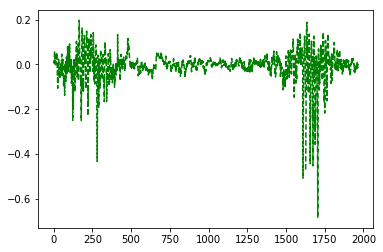

In [25]:
res_df['diff_norm'].plot(style='g--')

In [26]:
res_df['diff_norm'].abs().describe()

count    1965.000000
mean        0.035817
std         0.049827
min         0.000004
25%         0.008812
50%         0.020709
75%         0.043397
max         0.685466
Name: diff_norm, dtype: float64

In [27]:
Q1 = res_df['diff_norm'].abs().quantile(0.05)
print Q1
Q3 = res_df['diff_norm'].abs().quantile(0.95)
print Q3
IQR = Q3 - Q1
IQR

0.0019650477142
0.116764381144


0.11479933343009611

In [28]:
res_df[res_df['diff_norm'].abs() > 0.40]

ds         y     trend  trend_lower  trend_upper  \
281  2017-11-21 05:27:00  1.945910  4.414176     4.414176     4.414176   
1610 2017-11-22 03:36:00  1.791759  4.429150     4.429150     4.429150   
1627 2017-11-22 03:53:00  1.791759  4.429431     4.429431     4.429431   
1656 2017-11-22 04:22:00  1.791759  4.429909     4.429909     4.429909   
1674 2017-11-22 04:40:00  1.791759  4.430206     4.430206     4.430206   
1704 2017-11-22 05:10:00  1.791759  4.430702     4.430702     4.430702   
1705 2017-11-22 05:11:00  1.609438  4.430718     4.430718     4.430718   

      yhat_lower  yhat_upper     daily  daily_lower  daily_upper  seasonal  \
281     2.551842    3.016260 -1.625733    -1.625733    -1.625733 -1.625733   
1610    2.466107    2.923476 -1.727978    -1.727978    -1.727978 -1.727978   
1627    2.390277    2.872379 -1.796344    -1.796344    -1.796344 -1.796344   
1656    2.363367    2.813536 -1.843567    -1.843567    -1.843567 -1.843567   
1674    2.363063    2.838968 -1.826911    -1.826911    -1.826911 -1.826911   
1704    2.496142    2.962240 -1.723068    -1.723068    -1.723068 -1.723068   
1705    2.465505    2.949423 -1.718065    -1.718065    -1.718065 -1.718065   

      seasonal_lower  seasonal_upper  seasonalities  seasonalities_lower  \
281        -1.625733       -1.625733      -1.625733            -1.625733   
1610       -1.727978       -1.727978      -1.727978            -1.727978   
1627       -1.796344       -1.796344      -1.796344            -1.796344   
1656       -1.843567       -1.843567      -1.843567            -1.843567   
1674       -1.826911       -1.826911      -1.826911            -1.826911   
1704       -1.723068       -1.723068      -1.723068            -1.723068   
1705       -1.718065       -1.718065      -1.718065            -1.718065   

      seasonalities_upper      yhat      diff  diff_norm  
281             -1.625733  2.788444 -0.842533  -0.432977  
1610            -1.727978  2.701172 -0.909412  -0.507553  
1627            -1.796344  2.633086 -0.841327  -0.469554  
1656            -1.843567  2.586342 -0.794582  -0.443465  
1674            -1.826911  2.603296 -0.811536  -0.452927  
1704            -1.723068  2.707634 -0.915874  -0.511159  
1705            -1.718065  2.712653 -1.103215  -0.685466

In [29]:
res_df.query('(@Q1 - 1.5 * @IQR) <= diff_norm <= (@Q3 + 1.5 * @IQR)')

ds         y     trend  trend_lower  trend_upper  \
0    2017-11-21 00:46:00  3.871201  4.114094     4.114094     4.114094   
1    2017-11-21 00:47:00  3.850148  4.115504     4.115504     4.115504   
2    2017-11-21 00:48:00  3.850148  4.116915     4.116915     4.116915   
3    2017-11-21 00:49:00  3.828641  4.118326     4.118326     4.118326   
4    2017-11-21 00:50:00  3.891820  4.119737     4.119737     4.119737   
5    2017-11-21 00:51:00  3.951244  4.121147     4.121147     4.121147   
6    2017-11-21 00:52:00  4.007333  4.122558     4.122558     4.122558   
7    2017-11-21 00:53:00  3.951244  4.123969     4.123969     4.123969   
8    2017-11-21 00:54:00  3.871201  4.125380     4.125380     4.125380   
9    2017-11-21 00:55:00  3.891820  4.126790     4.126790     4.126790   
10   2017-11-21 00:56:00  3.806662  4.128201     4.128201     4.128201   
11   2017-11-21 00:57:00  3.761200  4.129612     4.129612     4.129612   
12   2017-11-21 00:58:00  3.713572  4.131023     4.131023     4.131023   
13   2017-11-21 00:59:00  3.784190  4.132433     4.132433     4.132433   
14   2017-11-21 01:00:00  3.761200  4.133844     4.133844     4.133844   
15   2017-11-21 01:01:00  3.828641  4.135255     4.135255     4.135255   
16   2017-11-21 01:02:00  3.850148  4.136666     4.136666     4.136666   
17   2017-11-21 01:03:00  3.891820  4.138076     4.138076     4.138076   
18   2017-11-21 01:04:00  3.871201  4.139487     4.139487     4.139487   
19   2017-11-21 01:05:00  3.806662  4.140898     4.140898     4.140898   
20   2017-11-21 01:06:00  3.891820  4.142309     4.142309     4.142309   
21   2017-11-21 01:07:00  3.784190  4.143719     4.143719     4.143719   
22   2017-11-21 01:08:00  3.761200  4.145130     4.145130     4.145130   
23   2017-11-21 01:09:00  3.610918  4.146541     4.146541     4.146541   
24   2017-11-21 01:10:00  3.496508  4.147952     4.147952     4.147952   
25   2017-11-21 01:11:00  3.496508  4.149362     4.149362     4.149362   
26   2017-11-21 01:12:00  3.295837  4.150773     4.150773     4.150773   
27   2017-11-21 01:13:00  3.332205  4.152184     4.152184     4.152184   
28   2017-11-21 01:14:00  3.401197  4.153595     4.153595     4.153595   
29   2017-11-21 01:15:00  3.526361  4.155005     4.155005     4.155005   
...                  ...       ...       ...          ...          ...   
1936 2017-11-22 09:02:00  4.718499  4.434531     4.434531     4.434531   
1937 2017-11-22 09:03:00  4.727388  4.434548     4.434548     4.434548   
1938 2017-11-22 09:04:00  4.718499  4.434564     4.434564     4.434564   
1939 2017-11-22 09:05:00  4.727388  4.434581     4.434581     4.434581   
1940 2017-11-22 09:06:00  4.663439  4.434597     4.434597     4.434597   
1941 2017-11-22 09:07:00  4.584967  4.434614     4.434614     4.434614   
1942 2017-11-22 09:08:00  4.663439  4.434630     4.434630     4.434630   
1943 2017-11-22 09:09:00  4.584967  4.434647     4.434647     4.434647   
1944 2017-11-22 09:10:00  4.584967  4.434663     4.434663     4.434663   
1945 2017-11-22 09:11:00  4.615121  4.434680     4.434680     4.434680   
1946 2017-11-22 09:12:00  4.691348  4.434696     4.434696     4.434696   
1947 2017-11-22 09:13:00  4.736198  4.434713     4.434713     4.434713   
1948 2017-11-22 09:14:00  4.691348  4.434729     4.434729     4.434729   
1949 2017-11-22 09:15:00  4.709530  4.434746     4.434746     4.434746   
1950 2017-11-22 09:16:00  4.700480  4.434762     4.434762     4.434762   
1951 2017-11-22 09:17:00  4.709530  4.434779     4.434779     4.434779   
1952 2017-11-22 09:18:00  4.682131  4.434795     4.434795     4.434795   
1953 2017-11-22 09:19:00  4.736198  4.434812     4.434812     4.434812   
1954 2017-11-22 09:20:00  4.736198  4.434828     4.434828     4.434828   
1955 2017-11-22 09:21:00  4.718499  4.434845     4.434845     4.434845   
1956 2017-11-22 09:22:00  4.787492  4.434861     4.434861     4.434861   
1957 2017-11-22 09:23:00  4.836282  4.434878     4.434878     4.434878   
1958 2017-11-22 09:24:00  

In [30]:
load_timeseries = res_df['diff_norm'].values
load_timeseries_length = len(load_timeseries)


In [31]:
from array import array

In [32]:
from __future__ import division
import numpy as np

class AnomalyDetector(object):

    def __init__(self, window = 10):
        self._index = 0
        self._window = window
        self._values = np.zeros(window)
        self._valuesSq = np.zeros(window)
        self._mean = 0
        self._variance = 0
        self._count = 0

    def observation(self, value):
        anomaly = False

        threshold = 3 * np.sqrt(self._variance)
        if self._count > self._window:
            if value > self._mean + threshold:
                value = self._mean + threshold
                anomaly = True
            elif value < self._mean - threshold:
                value = self._mean - threshold
                anomaly = True
        else:
            self._count += 1

        prev_value = self._values[self._index]
        self._values[self._index] = value
        self._valuesSq[self._index] = value ** 2
        self._index = (self._index + 1) % self._window

        self._mean = self._mean - prev_value / self._window + value / self._window
        self._variance = sum(self._valuesSq) / self._window - (self._mean ** 2)

        return anomaly, self._mean

In [33]:

load_anomalies = np.zeros(load_timeseries_length)
load_means = np.zeros(load_timeseries_length)

load_anomaly_detector = AnomalyDetector(36)

for i, value in enumerate(load_timeseries):
    anomaly, mean = load_anomaly_detector.observation(value)

    load_anomalies[i] = anomaly
    load_means[i] = mean

In [34]:
#[i for i in load_anomalies if i == 1]

In [35]:
res_df['anomaly'] = load_anomalies
res_df['means'] = load_means
res_df[res_df['anomaly'] == 1]
df_anoms = res_df[res_df['anomaly'] == 1]
df_anoms.head()

ds         y     trend  trend_lower  trend_upper  \
123 2017-11-21 02:49:00  2.302585  4.287615     4.287615     4.287615   
124 2017-11-21 02:50:00  2.397895  4.289026     4.289026     4.289026   
177 2017-11-21 03:43:00  2.197225  4.363796     4.363796     4.363796   
178 2017-11-21 03:44:00  2.079442  4.365206     4.365206     4.365206   
221 2017-11-21 04:27:00  2.079442  4.398021     4.398021     4.398021   

     yhat_lower  yhat_upper     daily  daily_lower  daily_upper    ...     \
123    2.650875    3.106862 -1.409593    -1.409593    -1.409593    ...      
124    2.651555    3.113259 -1.417943    -1.417943    -1.417943    ...      
177    2.365684    2.839727 -1.759581    -1.759581    -1.759581    ...      
178    2.374888    2.838222 -1.763708    -1.763708    -1.763708    ...      
221    2.329808    2.786299 -1.842485    -1.842485    -1.842485    ...      

     seasonal_lower  seasonal_upper  seasonalities  seasonalities_lower  \
123       -1.409593       -1.409593      -1.409593            -1.409593   
124       -1.417943       -1.417943      -1.417943            -1.417943   
177       -1.759581       -1.759581      -1.759581            -1.759581   
178       -1.763708       -1.763708      -1.763708            -1.763708   
221       -1.842485       -1.842485      -1.842485            -1.842485   

     seasonalities_upper      yhat      diff  diff_norm  anomaly     means  
123            -1.409593  2.878023 -0.575438  -0.249909      1.0 -0.003181  
124            -1.417943  2.871083 -0.473188  -0.197335      1.0 -0.008832  
177            -1.759581  2.604214 -0.406990  -0.185229      1.0  0.037813  
178            -1.763708  2.601498 -0.522057  -0.251056      1.0  0.032000  
221            -1.842485  2.555536 -0.476095  -0.228953      1.0  0.033050  

[5 rows x 21 columns]

In [36]:
res_df['means'].describe()

count    1626.000000
mean       -0.000309
std         0.019622
min        -0.048279
25%        -0.012373
50%         0.000182
75%         0.008976
max         0.063191
Name: means, dtype: float64

In [37]:
print load_anomalies
#range(load_timeseries_length)
res_df.ix[load_anomalies==1]

[ 0.  0.  0. ...,  0.  0.  0.]


/Users/jose/Documents/GitHub/google_cloud_playground/real_time_dashboard_client/venv/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


ds         y     trend  trend_lower  trend_upper  \
123  2017-11-21 02:49:00  2.302585  4.287615     4.287615     4.287615   
124  2017-11-21 02:50:00  2.397895  4.289026     4.289026     4.289026   
177  2017-11-21 03:43:00  2.197225  4.363796     4.363796     4.363796   
178  2017-11-21 03:44:00  2.079442  4.365206     4.365206     4.365206   
221  2017-11-21 04:27:00  2.079442  4.398021     4.398021     4.398021   
280  2017-11-21 05:26:00  2.197225  4.414197     4.414197     4.414197   
281  2017-11-21 05:27:00  1.945910  4.414176     4.414176     4.414176   
282  2017-11-21 05:28:00  2.197225  4.414156     4.414156     4.414156   
413  2017-11-21 07:39:00  4.634729  4.412225     4.412225     4.412225   
478  2017-11-21 08:44:00  5.181784  4.412295     4.412295     4.412295   
479  2017-11-21 08:45:00  5.123964  4.412297     4.412297     4.412297   
480  2017-11-21 08:46:00  5.164786  4.412298     4.412298     4.412298   
545  2017-11-21 09:51:00  4.770685  4.412368     4.412368     4.412368   
546  2017-11-21 09:52:00  4.700480  4.412369     4.412369     4.412369   
547  2017-11-21 09:53:00  4.718499  4.412371     4.412371     4.412371   
636  2017-11-21 11:22:00  4.867534  4.413118     4.413118     4.413118   
638  2017-11-21 11:24:00  4.897840  4.413151     4.413151     4.413151   
663  2017-11-21 11:49:00  5.375278  4.413565     4.413565     4.413565   
664  2017-11-21 11:50:00  5.468060  4.413582     4.413582     4.413582   
665  2017-11-21 11:51:00  5.476464  4.413598     4.413598     4.413598   
810  2017-11-21 14:16:00  4.844187  4.415986     4.415986     4.415986   
818  2017-11-21 14:24:00  4.787492  4.416118     4.416118     4.416118   
967  2017-11-21 16:53:00  4.955827  4.418568     4.418568     4.418568   
973  2017-11-21 16:59:00  4.890349  4.418667     4.418667     4.418667   
974  2017-11-21 17:00:00  4.852030  4.418684     4.418684     4.418684   
1075 2017-11-21 18:41:00  5.313206  4.420345     4.420345     4.420345   
1076 2017-11-21 18:42:00  5.308268  4.420361     4.420361     4.420361   
1147 2017-11-21 19:53:00  5.159055  4.421529     4.421529     4.421529   
1148 2017-11-21 19:54:00  5.198497  4.421545     4.421545     4.421545   
1149 2017-11-21 19:55:00  5.236442  4.421562     4.421562     4.421562   
1150 2017-11-21 19:56:00  5.209486  4.421578     4.421578     4.421578   
1263 2017-11-21 21:49:00  4.955827  4.423437     4.423437     4.423437   
1385 2017-11-21 23:51:00  4.369448  4.425443     4.425443     4.425443   
1479 2017-11-22 01:25:00  3.465736  4.426989     4.426989     4.426989   
1481 2017-11-22 01:27:00  3.401197  4.427022     4.427022     4.427022   
1482 2017-11-22 01:28:00  3.401197  4.427039     4.427039     4.427039   
1552 2017-11-22 02:38:00  2.772589  4.428193     4.428193     4.428193   
1553 2017-11-22 02:39:00  2.708050  4.428209     4.428209     4.428209   
1608 2017-11-22 03:34:00  2.397895  4.429117     4.429117     4.429117   
1609 2017-11-22 03:35:00  2.302585  4.429134     4.429134     4.429134   
1610 2017-11-22 03:36:00  1.791759  4.429150     4.429150     4.429150   
1611 2017-11-22 03:37:00  1.945910  4.429167     4.429167     4.429167   
1612 2017-11-22 03:38:00  2.302585  4.429183     4.429183     4.429183   

      yhat_lower  yhat_upper     daily  daily_lower  daily_upper    ...     \
123     2.650875    3.106862 -1.409593    -1.409593    -1.409593    ...      
124     2.651555    3.113259 -1.417943    -1.417943    -1.417943    ...      
177     2.365684    2.839727 -1.759581    -1.759581    -1.759581    ...      
178     2.374888    2.838222 -1.763708    -1.763708    -1.763708    ...      
221     2.329808    2.786299 -1.842485    -1.842485    -1.842485    ...      
280     2.563481    2.999086 -1.632153    -1.632153    -1.632153    ...      
281     2.551842    3.016260 -1.625733    -1.625733    -1.625733    ...      
282     2.560898    3.009597 -1.619230    -1.619230    -1.619230    ...      
413     3.758738    4.237013 -0.398375    -0.398375    -0.39837

In [38]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.graph_objs import *
#py.offline.init_notebook_mode()
from datetime import datetime
#import pandas_datareader.data as web

In [39]:
data = [go.Scatter(x=res_df['ds'], y=res_df['diff_norm'])]

In [40]:
import plotly
print(plotly.__version__)           # version 1.9.4 required
plotly.offline.init_notebook_mode() # run at the start of every notebook
plotly.offline.iplot(data, filename='pandas-time-series')

2.2.1


In [41]:
color1 = 'rgb(31, 119, 180)'
color2 = '#F08B00'

trace1 = go.Scatter(
    x = res_df['ds'],
    y = res_df['diff_norm'],
    name='metric value',mode='lines+markers',
    line = dict(
        color = color1
    )
)
trace2 = go.Scatter(
    x= df_anoms['ds'],
    y = df_anoms['diff_norm'] ,
    name='anoms',
    yaxis='y',
    mode='markers'

)
layout = go.Layout(
    title= "Real Time Anomalies",
    yaxis=dict(
        title='',
        titlefont=dict(
            color=color1
        ),
        tickfont=dict(
            color=color1
        )
    )

)
layout_bck = go.Layout(
    title= "Real Time Anomalies",
    yaxis=dict(
        title='collisions',
        titlefont=dict(
            color=color1
        ),
        tickfont=dict(
            color=color1
        )
    ),
    yaxis2=dict(
        title='anoms',
        overlaying='y',
        side='right',
        titlefont=dict(
            color=color2
        ),
        tickfont=dict(
            color=color2
        )

    )

)
data = [trace1, trace2]
fig = go.Figure(data=data, layout=layout)
#plot_url = py.iplot(fig)
plotly.offline.iplot(fig, filename='pandas-time-series')

In [42]:
upper_bound = go.Scatter(
    name='Upper Bound',
    x=res_df['ds'],
    y=np.exp(res_df['yhat_upper']),
    mode='lines',
    marker=dict(color="444"),
    line=dict(width=0),
    fillcolor='rgba(68, 68, 68, 0.3)',
    fill='tonexty' )

trace = go.Scatter(
    name='Metric',
    x=res_df['ds'],
    y=np.exp(res_df['yhat']),
    mode='lines',
    line=dict(color='rgb(31, 119, 180)'),
    fillcolor='rgba(68, 68, 68, 0.3)',
    fill='tonexty' )

lower_bound = go.Scatter(
    name='Lower Bound',
    x=res_df['ds'],
    y=np.exp(res_df['yhat_lower']),
    marker=dict(color="444"),
    line=dict(width=0),
    mode='lines' )

# Trace order can be important
# with continuous error bars
data = [lower_bound, trace, upper_bound]

layout = go.Layout(
    yaxis=dict(title='Value'),
    title='Real time data',
    showlegend = False)
fig = go.Figure(data=data, layout=layout)

#py.iplot(fig, filename='pandas-time-series-error-bars')
url_1 = py.plot(data, filename='real-time-data', auto_open=False)
plotly.offline.iplot(fig, filename='real-time-data')

# BQ

In [43]:
res_df.head()

ds         y     trend  trend_lower  trend_upper  \
0 2017-11-21 00:46:00  3.871201  4.114094     4.114094     4.114094   
1 2017-11-21 00:47:00  3.850148  4.115504     4.115504     4.115504   
2 2017-11-21 00:48:00  3.850148  4.116915     4.116915     4.116915   
3 2017-11-21 00:49:00  3.828641  4.118326     4.118326     4.118326   
4 2017-11-21 00:50:00  3.891820  4.119737     4.119737     4.119737   

   yhat_lower  yhat_upper     daily  daily_lower  daily_upper    ...     \
0    3.589321    4.050551 -0.292262    -0.292262    -0.292262    ...      
1    3.596334    4.048874 -0.299905    -0.299905    -0.299905    ...      
2    3.581483    4.045562 -0.307596    -0.307596    -0.307596    ...      
3    3.559504    4.034710 -0.315335    -0.315335    -0.315335    ...      
4    3.586199    4.042325 -0.323121    -0.323121    -0.323121    ...      

   seasonal_lower  seasonal_upper  seasonalities  seasonalities_lower  \
0       -0.292262       -0.292262      -0.292262            -0.292262   
1       -0.299905       -0.299905      -0.299905            -0.299905   
2       -0.307596       -0.307596      -0.307596            -0.307596   
3       -0.315335       -0.315335      -0.315335            -0.315335   
4       -0.323121       -0.323121      -0.323121            -0.323121   

   seasonalities_upper      yhat      diff  diff_norm  anomaly     means  
0            -0.292262  3.821831  0.049370   0.012753      0.0  0.000354  
1            -0.299905  3.815599  0.034548   0.008973      0.0  0.000604  
2            -0.307596  3.809319  0.040828   0.010604      0.0  0.000898  
3            -0.315335  3.802991  0.025650   0.006700      0.0  0.001084  
4            -0.323121  3.796615  0.095205   0.024463      0.0  0.001764  

[5 rows x 21 columns]

In [44]:
def _generate_bq_schema(df, default_type='STRING'):
    """ Given a passed df, generate the associated Google BigQuery schema.
    Parameters
    ----------
    df : DataFrame
    default_type : string
        The default big query type in case the type of the column
        does not exist in the schema.
    """

    type_mapping = {
        'i': 'INTEGER',
        'b': 'BOOLEAN',
        'f': 'FLOAT',
        'O': 'STRING',
        'S': 'STRING',
        'U': 'STRING',
        'M': 'TIMESTAMP'
    }

    fields = []
    for column_name, dtype in df.dtypes.iteritems():
        fields.append({'name': column_name,
                       'type': type_mapping.get(dtype.kind, default_type)})

    return {'fields': fields}


In [45]:
schema = _generate_bq_schema(res_df, default_type='STRING')
schema['fields']

[{'name': u'ds', 'type': 'TIMESTAMP'},
 {'name': u'y', 'type': 'FLOAT'},
 {'name': u'trend', 'type': 'FLOAT'},
 {'name': u'trend_lower', 'type': 'FLOAT'},
 {'name': u'trend_upper', 'type': 'FLOAT'},
 {'name': u'yhat_lower', 'type': 'FLOAT'},
 {'name': u'yhat_upper', 'type': 'FLOAT'},
 {'name': u'daily', 'type': 'FLOAT'},
 {'name': u'daily_lower', 'type': 'FLOAT'},
 {'name': u'daily_upper', 'type': 'FLOAT'},
 {'name': u'seasonal', 'type': 'FLOAT'},
 {'name': u'seasonal_lower', 'type': 'FLOAT'},
 {'name': u'seasonal_upper', 'type': 'FLOAT'},
 {'name': u'seasonalities', 'type': 'FLOAT'},
 {'name': u'seasonalities_lower', 'type': 'FLOAT'},
 {'name': u'seasonalities_upper', 'type': 'FLOAT'},
 {'name': u'yhat', 'type': 'FLOAT'},
 {'name': 'diff', 'type': 'FLOAT'},
 {'name': 'diff_norm', 'type': 'FLOAT'},
 {'name': 'anomaly', 'type': 'FLOAT'},
 {'name': 'means', 'type': 'FLOAT'}]

In [59]:
created = client.create_table('streaming', 'fcst', schema['fields'])
print created

INFO:googleapiclient.discovery:URL being requested: POST https://www.googleapis.com/bigquery/v2/projects/eam-poc-realtime/datasets/streaming/tables?alt=json


True


In [60]:
exists = client.check_table('streaming', 'fcst')
print exists

INFO:googleapiclient.discovery:URL being requested: GET https://www.googleapis.com/bigquery/v2/projects/eam-poc-realtime/datasets/streaming/tables/fcst?alt=json


True


In [48]:
res_df['ds'] = res_df['ds'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))
res_df.head()

ds         y     trend  trend_lower  trend_upper  \
0  2017-11-21 00:46:00  3.871201  4.114094     4.114094     4.114094   
1  2017-11-21 00:47:00  3.850148  4.115504     4.115504     4.115504   
2  2017-11-21 00:48:00  3.850148  4.116915     4.116915     4.116915   
3  2017-11-21 00:49:00  3.828641  4.118326     4.118326     4.118326   
4  2017-11-21 00:50:00  3.891820  4.119737     4.119737     4.119737   

   yhat_lower  yhat_upper     daily  daily_lower  daily_upper    ...     \
0    3.589321    4.050551 -0.292262    -0.292262    -0.292262    ...      
1    3.596334    4.048874 -0.299905    -0.299905    -0.299905    ...      
2    3.581483    4.045562 -0.307596    -0.307596    -0.307596    ...      
3    3.559504    4.034710 -0.315335    -0.315335    -0.315335    ...      
4    3.586199    4.042325 -0.323121    -0.323121    -0.323121    ...      

   seasonal_lower  seasonal_upper  seasonalities  seasonalities_lower  \
0       -0.292262       -0.292262      -0.292262            -0.292262   
1       -0.299905       -0.299905      -0.299905            -0.299905   
2       -0.307596       -0.307596      -0.307596            -0.307596   
3       -0.315335       -0.315335      -0.315335            -0.315335   
4       -0.323121       -0.323121      -0.323121            -0.323121   

   seasonalities_upper      yhat      diff  diff_norm  anomaly     means  
0            -0.292262  3.821831  0.049370   0.012753      0.0  0.000354  
1            -0.299905  3.815599  0.034548   0.008973      0.0  0.000604  
2            -0.307596  3.809319  0.040828   0.010604      0.0  0.000898  
3            -0.315335  3.802991  0.025650   0.006700      0.0  0.001084  
4            -0.323121  3.796615  0.095205   0.024463      0.0  0.001764  

[5 rows x 21 columns]

In [49]:

res_df['means'].fillna(0, inplace=True)
res_df['diff_norm'].fillna(0, inplace=True)
#res_df = res_df.dropna(subset=["diff_norm", "means"], how="all")
res_df = res_df.dropna(how='any') 
res_df.describe()

y        trend  trend_lower  trend_upper   yhat_lower  \
count  1966.000000  1966.000000  1966.000000  1966.000000  1966.000000   
mean      4.146016     4.403950     4.403950     4.403950     3.914070   
std       0.954994     0.057171     0.057171     0.057171     0.937151   
min       0.000000     4.114094     4.114094     4.114094     2.308080   
25%       3.295837     4.412683     4.412683     4.412683     3.006208   
50%       4.488636     4.418823     4.418823     4.418823     4.237534   
75%       5.003946     4.426903     4.426903     4.426903     4.789092   
max       5.476464     4.435010     4.435010     4.435010     4.989674   

        yhat_upper        daily  daily_lower  daily_upper     seasonal  \
count  1966.000000  1966.000000  1966.000000  1966.000000  1966.000000   
mean      4.377708    -0.257934    -0.257934    -0.257934    -0.257934   
std       0.937391     0.925156     0.925156     0.925156     0.925156   
min       2.770490    -1.843570    -1.843570    -1.843570    -1.843570   
25%       3.459931    -1.140081    -1.140081    -1.140081    -1.140081   
50%       4.702372     0.045094     0.045094     0.045094     0.045094   
75%       5.252693     0.604615     0.604615     0.604615     0.604615   
max       5.461391     0.786573     0.786573     0.786573     0.786573   

       seasonal_lower  seasonal_upper  seasonalities  seasonalities_lower  \
count     1966.000000     1966.000000    1966.000000          1966.000000   
mean        -0.257934       -0.257934      -0.257934            -0.257934   
std          0.925156        0.925156       0.925156             0.925156   
min         -1.843570       -1.843570      -1.843570            -1.843570   
25%         -1.140081       -1.140081      -1.140081            -1.140081   
50%          0.045094        0.045094       0.045094             0.045094   
75%          0.604615        0.604615       0.604615             0.604615   
max          0.786573        0.786573       0.786573             0.786573   

       seasonalities_upper         yhat          diff    diff_norm  \
count          1966.000000  1966.000000  1.966000e+03  1966.000000   
mean             -0.257934     4.146016  2.207775e-07    -0.002780   
std               0.925156     0.937387  1.811400e-01     0.061291   
min              -1.843570     2.550694 -2.636290e+00    -0.685466   
25%              -1.140081     3.233582 -8.602964e-02    -0.020570   
50%               0.045094     4.470976  4.323937e-03     0.000972   
75%               0.604615     5.022216  8.872937e-02     0.020778   
max               0.786573     5.200420  6.515443e-01     0.197687   

           anomaly        means  
count  1966.000000  1966.000000  
mean      0.021872    -0.000255  
std       0.146302     0.017845  
min       0.000000    -0.048279  
25%       0.000000    -0.009911  
50%       0.000000     0.000000  
75%       0.000000     0.006818  
max       1.000000     0.063191

In [50]:

rows = res_df.to_dict(orient='records')

#rows

In [67]:
import uuid
inserted = client.push_rows('streaming', 'fcst', rows,template_suffix='_active_users', insert_id_key=str(uuid.uuid4()))
#to_gbq(res_df, 'streaming.active_users_fcst', 'eam-poc-realtime')


INFO:googleapiclient.discovery:URL being requested: POST https://www.googleapis.com/bigquery/v2/projects/eam-poc-realtime/datasets/streaming/tables/fcst/insertAll?alt=json


In [68]:
inserted

True

In [53]:
res_df.tail()

ds         y     trend  trend_lower  trend_upper  \
1961  2017-11-22 09:27:00  4.859812  4.434944     4.434944     4.434944   
1962  2017-11-22 09:28:00  4.770685  4.434960     4.434960     4.434960   
1963  2017-11-22 09:29:00  4.836282  4.434977     4.434977     4.434977   
1964  2017-11-22 09:30:00  4.828314  4.434993     4.434993     4.434993   
1965  2017-11-22 09:31:00  4.882802  4.435010     4.435010     4.435010   

      yhat_lower  yhat_upper     daily  daily_lower  daily_upper  ...    \
1961    4.601903    5.060753  0.409353     0.409353     0.409353  ...     
1962    4.603100    5.079655  0.414493     0.414493     0.414493  ...     
1963    4.620424    5.090891  0.419592     0.419592     0.419592  ...     
1964    4.631045    5.102646  0.424649     0.424649     0.424649  ...     
1965    4.627384    5.094822  0.429665     0.429665     0.429665  ...     

      seasonal_lower  seasonal_upper  seasonalities  seasonalities_lower  \
1961        0.409353        0.409353       0.409353             0.409353   
1962        0.414493        0.414493       0.414493             0.414493   
1963        0.419592        0.419592       0.419592             0.419592   
1964        0.424649        0.424649       0.424649             0.424649   
1965        0.429665        0.429665       0.429665             0.429665   

      seasonalities_upper      yhat      diff  diff_norm  anomaly  means  
1961             0.409353  4.844297  0.015515   0.003193      0.0    0.0  
1962             0.414493  4.849454 -0.078769  -0.016511      0.0    0.0  
1963             0.419592  4.854569 -0.018287  -0.003781      0.0    0.0  
1964             0.424649  4.859642 -0.031329  -0.006489      0.0    0.0  
1965             0.429665  4.864675  0.018127   0.003712      0.0    0.0  

[5 rows x 21 columns]

In [54]:
stop here

SyntaxError: invalid syntax (<ipython-input-54-a96ba3aab008>, line 1)

## Dash

In [ ]:
import plotly.dashboard_objs as dashboard

import IPython.display
from IPython.display import Image

my_dboard = dashboard.Dashboard()
my_dboard.get_preview()

In [ ]:
import re

def fileId_from_url(url):
    """Return fileId from a url."""
    raw_fileId = re.findall("~[A-z]+/[0-9]+", url)[0][1: ]
    return raw_fileId.replace('/', ':')

def sharekey_from_url(url):
    """Return the sharekey from a url."""
    if 'share_key=' not in url:
        return "This url is not 'sercret'. It does not have a secret key."
    return url[url.find('share_key=') + len('share_key='):]

fileId_1 = fileId_from_url(url_1)

box_c = {
    'type': 'box',
    'boxType': 'plot',
    'fileId': fileId_1,
    'title': 'real-time-data',
    'shareKey': sharekey_from_url(url_1)
}

my_dboard.insert(box_c)

In [ ]:
my_dboard.get_box(1)

In [ ]:
my_dboard.get_box(1)['title'] = 'a new title'
my_dboard.get_box(1)

In [ ]:
my_dboard.get_preview()

In [ ]:
import plotly.plotly as py
py.dashboard_ops.upload(my_dboard, 'My First Dashboard with Python')

In [ ]:
import plotly.tools as tls
streams = ['us8o94u4go']
plotly.tools.set_credentials_file(username='analytics_eam', api_key='bXHED3dVs5f3ig0a9jZ2', stream_ids=streams)
stream_ids = tls.get_credentials_file()['stream_ids']
print stream_ids

In [ ]:
# Get stream id from stream id list 
stream_id = stream_ids[0]

# Make instance of stream id object 
stream_1 = go.Stream(
    token=stream_id,  # link stream id to 'token' key
    maxpoints=80      # keep a max of 80 pts on screen
)
stream_1 = dict(token=stream_id, maxpoints=60)

In [ ]:
trace1 = go.Scatter(
    x = res_df['ds'],
    y = res_df['diff_norm'],
    name='metric value',mode='lines+markers',
    stream= stream_1,
    line = dict(
        color = color1
    )
)

In [ ]:
data = go.Data([trace1])

In [ ]:
layout = go.Layout(title='Time Series')

# Make a figure object
fig = go.Figure(data=data, layout=layout)

# Send fig to Plotly, initialize streaming plot, open new tab
py.iplot(fig, filename='python-streaming')

In [ ]:
s = py.Stream(stream_id)

# We then open a connection
s.open()

In [ ]:
import datetime
import time

i = 0    # a counter
k = 5    # some shape parameter

# Delay start of stream by 5 sec (time to switch tabs)
time.sleep(5)

while True:

    # Current time on x-axis, random numbers on y-axis
    x = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')
    y = (np.cos(k*i/50.)*np.cos(i/50.)+np.random.randn(1))[0]

    # Send data to your plot
    s.write(dict(x=x, y=y))

    #     Write numbers to stream to append current data on plot,
    #     write lists to overwrite existing data on plot

    time.sleep(1)  # plot a point every second    
# Close the stream when done plotting
s.close()

In [ ]:
tls.embed('streaming-demos','12')

In [ ]:
ts